In [18]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
from linear_mcmc import *
import pandas as pd
from scipy.interpolate import interp1d

In [19]:
from sklearn.model_selection import train_test_split
import george
from george import kernels

def GPR(X, y, lnlikelihood=True):
  '''
  The output of this function is another function, either the lnlikelihood, or 
  the gp (the gaussian process regressor that is dfined by giving theta)
  '''
  n = X.shape[1]
    
  def step(theta):

        L = np.exp(theta[:n])
        sigma = np.exp(theta[n])   
        yerr = np.exp(theta[n+1])
        
        kernel = sigma * kernels.ExpSquaredKernel(np.ones(n), ndim=n)

        gp = george.GP(kernel)

        if lnlikelihood:
            
          gp = george.GP(kernel)
          gp.compute(X / np.vstack([L]*X.shape[0]), yerr)
       
          return -gp.lnlikelihood(y)
        else:
          X0 = X / np.vstack([L]*X.shape[0])
          gp.compute(X0, yerr)
          return gp
      
  return step

In [20]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [21]:
cf3 = pd.read_csv("../calibrators/cf3.csv", sep='|')

for col in cf3.columns:
    newcol = col.strip()
    cf3.rename(columns={col:newcol}, inplace=True)

cf3.set_index('PGC', inplace=True)
cf3.head()

/home/ehsan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (5,7,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Dist,Nd,DM,eDM,C,T,L,M,S,N,...,Vcgp,Vmgp,Vrms,bwMass12,L_Mass12,LDC,HDC,2M++,MKgp,Icnt
PGC,,,,,,,,,,,,,,,,,,,,,
4,50.58,1,33.52,0.4,NaN,NaN,NaN,NaN,NaN,NaN,...,4005,4048,25.0,0.0,9.747,0,0,0,0,0
27,150.66,1,35.89,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,10959,11275,NaN,0.0,0.000,0,0,0,0,0
40,116.95,1,35.34,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,6919,7045,0.0,0.0,3.960,0,0,0,0,0
51,240.99,1,36.91,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,14743,15315,132.0,0.0,253.333,0,0,0,0,0
55,73.79,1,34.34,0.4,NaN,NaN,NaN,NaN,NaN,NaN,...,4454,4507,NaN,0.0,0.000,0,0,0,0,0


In [22]:
cf4 = pd.read_csv("../calibrators/DMs_EDD.csv.test", sep='|')


for col in cf4.columns:
    newcol = col.strip()
    cf4.rename(columns={col:newcol}, inplace=True)

cf4.set_index('pgc', inplace=True)
cf4.head()

,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,inc,Sqlt,Wqlt,...,pgc1,Nest,Vmodg,Nkt,N15,sglg,sgbg,RS,P0,DM_src
pgc,,,,,,,,,,,,,,,,,,,,,
2,5004,5296,4726,4786,1.013,2.744,0.029,52,0,5,...,73150,200275,4976,0,7,341.4922,20.7395,2,2.02,2
4,4458,4706,4109,4154,1.011,2.189,0.014,85,5,4,...,120,202766,4154,0,0,316.0587,18.4514,2,-2.75,1
12,6548,6685,6195,6297,1.016,2.606,0.021,82,0,5,...,12,210177,6279,0,1,286.4249,11.3510,2,0.56,2
16,5667,5809,5312,5387,1.014,2.515,0.025,65,5,5,...,16,211419,5434,0,1,287.6120,11.7030,2,0.92,1
55,4779,5052,4454,4507,1.012,2.260,0.025,80,5,4,...,55,0,4507,0,0,327.0996,19.7763,2,-2.83,1


In [23]:
def makeTF(logW, band):
    
    if band=='r':
        Sh=-7.37 ; Zh=-20.60
        Sl=-10.32; Zl=-20.86
        logW0=2.41
    elif band=='i':
        Sh=-7.60 ; Zh=-20.85
        Sl=-10.75; Zl=-21.08
        logW0=2.41        
    elif band=='z':
        Sh=-7.61 ; Zh=-20.96
        Sl=-10.78; Zl=-21.15
        logW0=2.44        
    
    Mh = Sh * (logW-2.5) + Zh
    Ml = Sl * (logW-2.5) + Zl
    M = np.asarray([Ml[i] if logW[i]<=logW0 else Mh[i] for i in range(len(logW))])
    
    return M


def MakeHUB(V, DM):
    
    logD = (DM-25)/5.
    logH = np.log10(V) - logD
    H0 = 10**logH
    
    return H0, logH

In [24]:
cf4["DMi_new"] = cf4['iii'].values - makeTF(cf4.logWimx.values, 'i')

cf4[["DMi", "DMi_new"]].head(7)

,DMi,DMi_new
pgc,,
2,0.00,22.70440
4,32.96,32.85675
12,0.00,21.65560
16,34.74,34.54400
55,33.89,33.72000
68,35.03,34.41750
70,35.18,35.12360


In [25]:

df = cf4[(cf4.Sqlt>2)&(cf4.Vmod>4000)]

df["H0_new"], df["logH_new"] = MakeHUB(df.Vmod, df.DMi_new)
df["H0"], df["logH"] = MakeHUB(df.Vmod, df.DMi)
# df["H0_3"], df["logH_3"] = MakeHUB(df.Vmod, df.DM)

df.head()

<ipython-input-25-c04d8c393655>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["H0_new"], df["logH_new"] = MakeHUB(df.Vmod, df.DMi_new)
<ipython-input-25-c04d8c393655>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["H0"], df["logH"] = MakeHUB(df.Vmod, df.DMi)


,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,inc,Sqlt,Wqlt,...,sglg,sgbg,RS,P0,DM_src,DMi_new,H0_new,logH_new,H0,logH
pgc,,,,,,,,,,,,,,,,,,,,,
4,4458,4706,4109,4154,1.011,2.189,0.014,85,5,4,...,316.0587,18.4514,2,-2.75,1,32.85675,111.459346,2.047116,106.283658,2.026466
16,5667,5809,5312,5387,1.014,2.515,0.025,65,5,5,...,287.6120,11.7030,2,0.92,1,34.54400,66.457955,1.822547,60.722127,1.783347
55,4779,5052,4454,4507,1.012,2.260,0.025,80,5,4,...,327.0996,19.7763,2,-2.83,1,33.72000,81.262010,1.909888,75.142832,1.875888
68,7664,7740,7338,7480,1.019,2.390,0.043,57,5,5,...,274.3903,7.1770,2,-0.35,1,34.41750,97.814130,1.990402,73.773706,1.867902
70,6800,7040,6447,6557,1.017,2.636,0.005,90,5,5,...,313.2488,17.7663,2,-0.74,1,35.12360,61.941994,1.791985,60.353878,1.780705


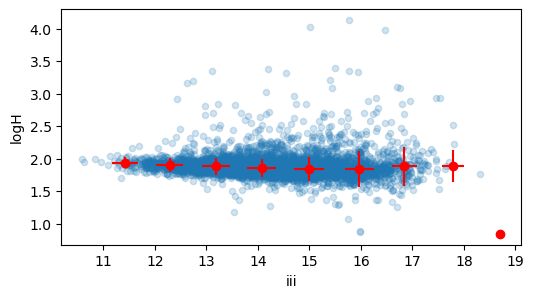

In [26]:
fig = py.figure(figsize=(5, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(3,1) ; p=0

ax = plt.subplot(gs[p]) ; p+=1

df.plot.scatter(x='iii', y='logH', alpha=0.2, ax=ax)

X = df['iii'].values
Y = df['logH'].values
xmin = np.min(X)
xmax = np.max(X)
for i in np.arange(xmin, xmax, 1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and not np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6) 

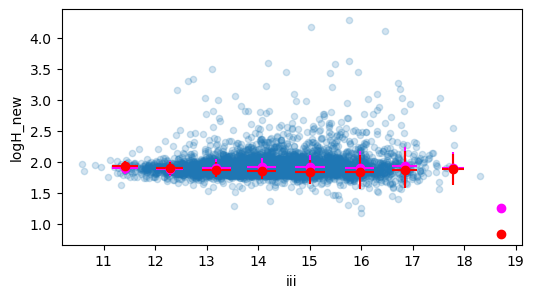

In [27]:
fig = py.figure(figsize=(5, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(3,1) ; p=0

ax = plt.subplot(gs[p]) ; p+=1

df.plot.scatter(x='iii', y='logH_new', alpha=0.2, ax=ax)

X = df['iii'].values
Y = df['logH_new'].values
xmin = np.min(X)
xmax = np.max(X)
for i in np.arange(xmin, xmax, 1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and not np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='magenta', ms=6) 
        
        
X = df['iii'].values
Y = df['logH'].values
xmin = np.min(X)
xmax = np.max(X)
for i in np.arange(xmin, xmax, 1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1 and not np.isnan(Y[ii]):
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6) 

In [28]:
from scipy.optimize import curve_fit


def myHubble(D, H0):
    return H0    

def PlotMe(ax, df, low, high, color='r', delta=0, label=None, param='DM', quality='Sqlt', mag='i'):
    
    dff = df[(df[param]>low) & (df[param]<high) & (df.Vmod > 0) & (df[quality]>2)]
    dff.plot.scatter(
                     x="iii", y='H0_new', alpha=0.1, ax=ax, color='k', s=2
                     )

    X = dff["iii"].values
    Y = dff['H0'].values+delta
    xmin = np.min(X)
    xmax = np.max(X)
    lab = True
    for i in np.arange(xmin, xmax, 1):
        xp = []
        yp = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+1 and not np.isnan(Y[ii]):
                xp.append(xi)
                yp.append(Y[ii])
        if len(xp)>0:
            if lab:
                labe = label
                lab = False
            else:
                labe=None
                
            xp = np.asarray(xp)
            yp = np.asarray(yp)
            ax.errorbar(np.mean(xp), 10**np.mean(np.log10(yp)), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color=color, ms=6, label=labe)     
#             print np.median(xp), 10**np.median(yp)

    x_ax, y_ax = set_axes(ax, (5,18), (35,150), fontsize=14) 
    ax.set_yscale('log')
    
    from matplotlib.ticker import MultipleLocator

    from matplotlib.ticker import NullFormatter
    
    ax.set_yticks(np.arange(30,150, step=30))
    ax.yaxis.set_major_formatter(NullFormatter())  
    ax.yaxis.set_minor_formatter(NullFormatter())

    ax.yaxis.set_major_locator(MultipleLocator(30))
    ax.yaxis.set_minor_locator(MultipleLocator(10))

    plt.yticks([40, 70, 100, 130], ('40', '70', '100','130'))
    # ax.set_yticks(np.arange(50,140, step=10))



    y_ax.set_yticks(np.arange(30,150, step=30))
    y_ax.set_yscale('log')
    y_ax.yaxis.set_major_formatter(NullFormatter())  
    y_ax.yaxis.set_minor_formatter(NullFormatter())
    y_ax.yaxis.set_major_locator(MultipleLocator(30))
    y_ax.yaxis.set_minor_locator(MultipleLocator(10))    
    
    ax.set_ylabel(r'$H^{75}_{i}$', fontsize=18)
    ax.legend(loc=3)
    
    
    fit, cov = curve_fit(myHubble, X, dff.logH)
    m = fit[0]
    H0 = 10**m
    ax.plot([5,20], [H0, H0], '--', color='blue')

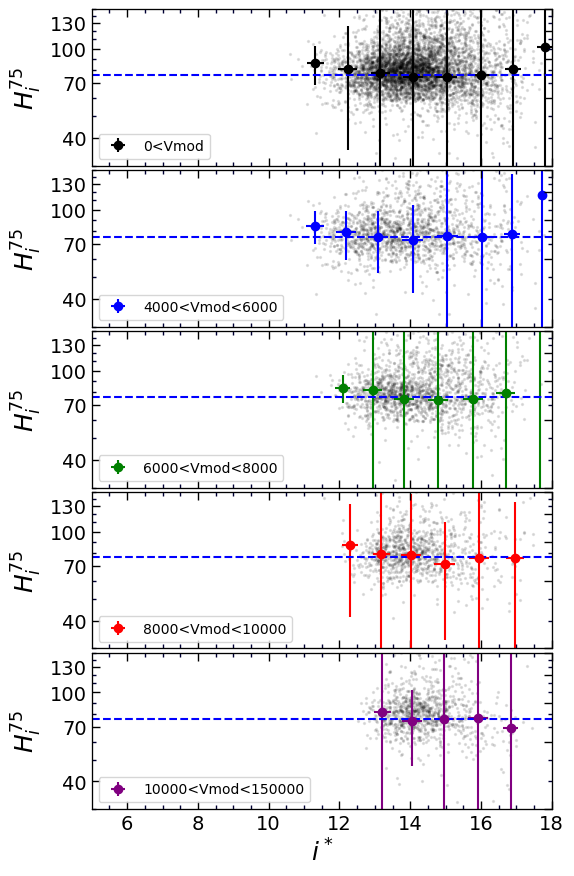

In [76]:
fig = py.figure(figsize=(5, 10), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(5,1) ; p=0

mag='i'


ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 4000, 20000, color='k', delta=0, label='0<Vmod', param='Vmod', mag=mag)

ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 4000, 6000, color='b', delta=0, label='4000<Vmod<6000', param='Vmod', mag=mag)

ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 6000, 8000, color='g', delta=0, label='6000<Vmod<8000', param='Vmod', mag=mag)

ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 8000, 10000, color='r', delta=0, label='8000<Vmod<10000', param='Vmod', mag=mag)

ax = plt.subplot(gs[p]) ; p+=1
PlotMe(ax, df, 10000, 15000, color='purple', delta=0, label='10000<Vmod<150000', param='Vmod', mag=mag)

ax.set_xlabel(r'$i^*$', fontsize=18)

plt.subplots_adjust(hspace=0.03, wspace=0.2)

In [30]:
# df = cf3[["DM"]].join(cf4[["Vmod", "DMi", "DMi_new","Sqlt", "iii", "logWimx"]][cf4.Sqlt>2], how='left').dropna()
# df["H0_new"], df["logH_new"] = MakeHUB(df.Vmod, df.DMi_new)
# df["H0"], df["logH"] = MakeHUB(df.Vmod, df.DMi)
# df["H0_3"], df["logH_3"] = MakeHUB(df.Vmod, df.DM)
# df.head()

2.2258769230769233 110.68656951096864
2.276159292035398 98.27241753018852
2.3251809744779584 90.22299645400156
2.3761240157480312 87.5682947396862
2.4242952029520293 80.31617708532644
2.472503333333333 82.11190894464296
2.5242306451612904 80.50392374479257
2.573943972835314 78.27533366821014
2.624122905027933 77.25753784997039
2.6719234828496043 74.60550900947743
2.720168888888889 71.14735263842664
2.7721071428571427 66.1560192392887
81.0180442178288


(<AxesSubplot:label='b7d86280-dc56-427f-8646-6185cd99f8e3'>,
 <AxesSubplot:label='d92dd758-1971-4165-9bdb-eb39d2421435'>)

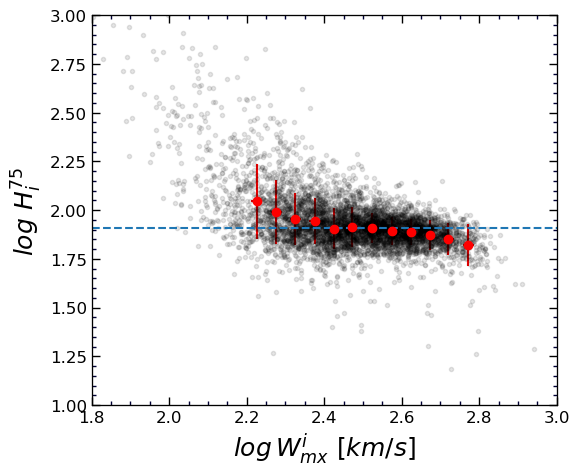

In [31]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = df.logWimx.values
Y = df.logH_new.values

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(2.2,2.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.mean(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     
        print(np.mean(xp), 10**np.mean(yp))

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(1.8,3,50)

ax.plot(v,0*v+np.median(Y), '--')

print(10**np.median(Y))

set_axes(ax, (1.8,3), (1,3), fontsize=12)

4565.91095890411 79.20543192681245
5431.841530054645 79.60691644081324
6566.094315245478 80.29242201800504
7445.204656862745 80.49109454428043
8485.735459662288 80.22412259836831
9474.355056179775 80.5208698334902
10509.055702917773 78.73407254222795
11497.404958677685 82.58564626331271
12443.71270718232 80.70928462328995
13450.852631578948 80.43280757232478
14434.708333333334 82.87913284688828
15534.264705882353 81.87714724251072
16507.333333333332 85.20729644690086
17406.208333333332 84.38867733882958
18313.583333333332 87.86063148727995
19271.333333333332 85.02359873147195


(<AxesSubplot:label='9fd48a13-e12a-467b-bcbc-1c2ee0193a3b'>,
 <AxesSubplot:label='7c0c8797-0318-4efe-8071-a39219dac676'>)

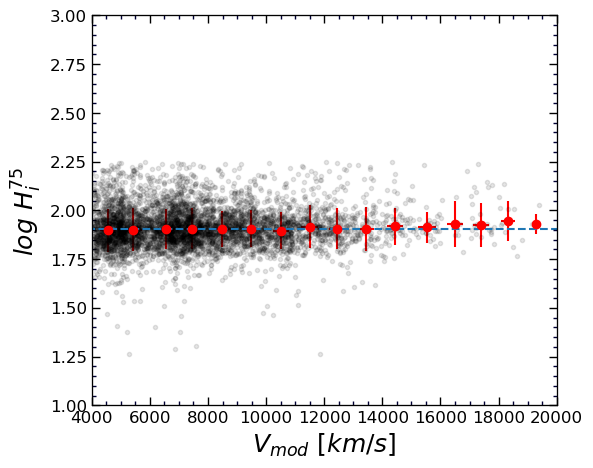

In [32]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = df.Vmod.values
Y = df.logH_new.values

ind, = np.where((Y<2.25)&(Y>1.25))
Y = Y[ind]
X=X[ind]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        print(np.mean(xp), 10**np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(0,20000,1000)

ax.plot(v,0*v+np.median(Y), '--')



set_axes(ax, (4000,20000), (1,3), fontsize=12)

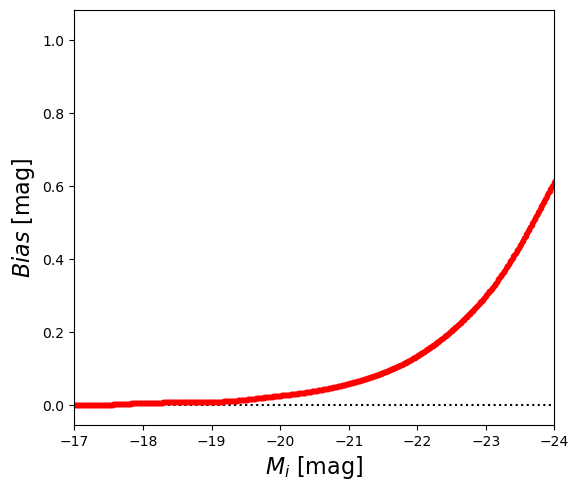

In [58]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-17, -24])

myDF = pd.read_csv("Malmquist_i.csv")

myDF['delta'] = myDF.M_real-myDF.M_observe

g1 = interp1d(myDF.M_observe.values, myDF.delta.values, kind='linear')

Ma = np.linspace(-24,-14,100)
ax.plot(Ma, g1(Ma), '-')

ax.set_xlabel(r'$M_{i}$'+' [mag]', fontsize=16)
ax.set_ylabel(r'$Bias$'+' [mag]', fontsize=16)

ax.plot([-17,-24],[0,0], 'k:')

ax.plot(myDF.M_observe.values, myDF.delta.values, 'r.')

In [59]:
myDF = pd.read_csv("GP_TF.csv")


myDF = myDF[myDF.Mag<-14]

myDF.head()

,Unnamed: 0,logW,Mag
0,0,2.907580,-25.000000
1,1,2.907571,-24.997500
2,2,2.907561,-24.994999
3,3,2.907550,-24.992499
4,4,2.907539,-24.989999


Text(0, 0.5, '$M^{75}_{i} \\/\\/ [AB]$')

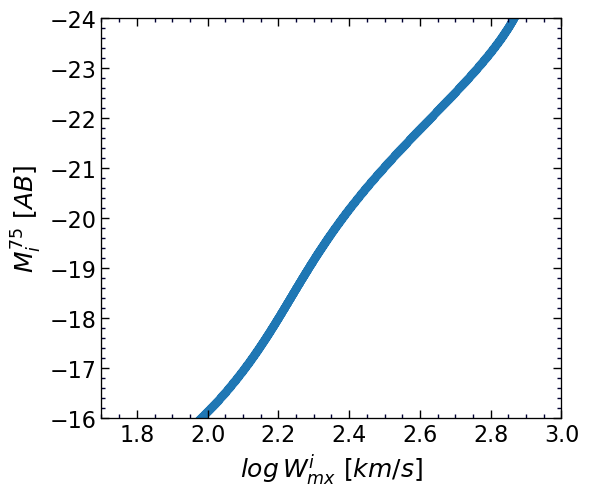

In [60]:
fig = py.figure(figsize=(5, 5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(1,1) ; p=0
ax = plt.subplot(gs[p]) ; p+=1

myDF.plot.scatter(x="logW", y="Mag", ax=ax)
set_axes(ax, (1.7,3), (-16,-24))

ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$M^{75}_{i} \/\/ [AB]$', fontsize=18)

In [61]:
minW = myDF.logW.values.min()
maxW = myDF.logW.values.max()

In [62]:


dff = df[(df.Vmod>4000) & (df['iii']>0) & (df.Sqlt>2)]

f1 = interp1d(myDF.logW.values, myDF.Mag.values, kind='linear')

logW = dff.logWimx.values


dff = dff[(dff.logWimx>minW)&(dff.logWimx<maxW)]
dff['I'] = f1(dff.logWimx)

dff = dff[(dff.I<-14)&(dff.I>-24)]

dff["DMi_new"] = dff['iii']-dff['I'] + g1(dff.I)
dff["H0_new"], dff["logH_new"] = MakeHUB(dff.Vmod, dff.DMi_new)

dff.head()

,Vh,Vls,V3k,Vmod,f_cosmology,logWimx,logWimx_e,inc,Sqlt,Wqlt,...,sgbg,RS,P0,DM_src,DMi_new,H0_new,logH_new,H0,logH,I
pgc,,,,,,,,,,,,,,,,,,,,,
4,4458,4706,4109,4154,1.011,2.189,0.014,85,5,4,...,18.4514,2,-2.75,1,33.014370,103.655546,2.015593,106.283658,2.026466,-17.889063
16,5667,5809,5312,5387,1.014,2.515,0.025,65,5,5,...,11.7030,2,0.92,1,34.799422,59.082998,1.771463,60.722127,1.783347,-21.152612
55,4779,5052,4454,4507,1.012,2.260,0.025,80,5,4,...,19.7763,2,-2.83,1,33.949834,73.100556,1.863921,75.142832,1.875888,-18.721438
68,7664,7740,7338,7480,1.019,2.390,0.043,57,5,5,...,7.1770,2,-0.35,1,34.646997,88.003959,1.944502,73.773706,1.867902,-20.098661
70,6800,7040,6447,6557,1.017,2.636,0.005,90,5,5,...,17.7663,2,-0.74,1,35.434627,53.675954,1.729780,60.353878,1.780705,-22.053537


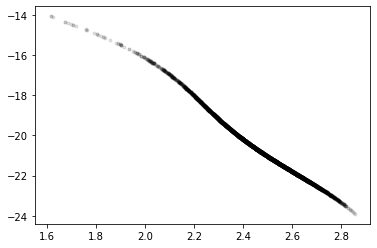

In [63]:
plt.plot(dff.logWimx, dff.I, 'k.', alpha=0.1)

2.2258769230769233 101.24837698619721
2.276159292035398 87.86695611276166
2.3251809744779584 79.86521804296413
2.3761240157480312 78.31666318700556
2.4242952029520293 73.76668233099332
2.472503333333333 74.06188931427715
2.5242306451612904 71.41796906916667
2.573943972835314 68.72044978336554
2.624122905027933 67.13234310545303
2.6719234828496043 63.87606806399978
2.720168888888889 59.416073871243995
2.7721071428571427 52.623939923781194
71.55713576579237


(<AxesSubplot:label='60795938-1420-418b-913b-b9908e683be7'>,
 <AxesSubplot:label='89d10c4b-54cf-4f92-8f88-5abd119c7171'>)

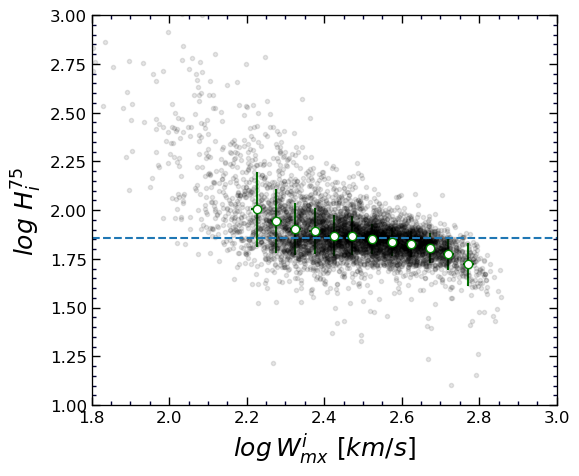

In [64]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.logWimx.values
Y = dff.logH_new.values

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(2.2,2.8,0.05):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.05:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.mean(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white')     
        print(np.mean(xp), 10**np.mean(yp))

        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(1.8,3,50)

ax.plot(v,0*v+np.median(Y), '--')


print(10**np.median(Y))

set_axes(ax, (1.8,3), (1,3), fontsize=12)

(<AxesSubplot:label='85ff2610-73ff-4c29-bf7a-e5fdcd83443e'>,
 <AxesSubplot:label='b4345d7f-f61e-4de8-9e85-30ba57783c1d'>)

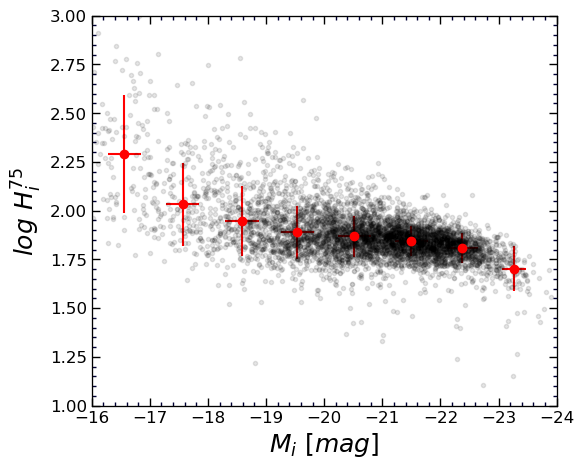

In [66]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.I.values
Y = dff.logH_new.values

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(-16,-24,-1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi<=i and xi>i-1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)     

        
ax.set_xlabel(r'$M_i \/\/[mag]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(1.8,3,50)

ax.plot(v,0*v+np.mean(Y), '--')



set_axes(ax, (-16, -24), (1,3), fontsize=12)

4566.812567713976 71.78474436446753
5437.755968169761 71.21338473583532
6563.253117206982 71.82280986693434
7445.938388625593 71.80529459469497
8488.613019891502 71.2654374402164
9474.235789473683 71.80572322077037
10506.859693877552 69.87648082745102
11502.251012145749 72.31649917599118
12437.907216494845 71.37824468651326
13444.154639175258 71.32953199332054
14450.065789473685 72.31384773040746
15522.885714285714 70.4870793620964
16536.1 76.405032678421
17406.653846153848 71.11478594830518
18350.46153846154 78.7722161788304
19271.333333333332 69.93435585736829


(<AxesSubplot:label='95428a49-be80-4fcc-b4c5-c3e5fb119d6e'>,
 <AxesSubplot:label='f8b0c7be-5cf5-4c78-8e0c-a656e2b3df3a'>)

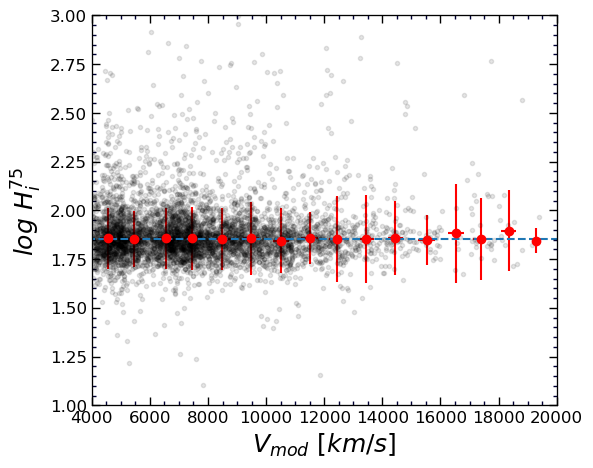

In [67]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.logH_new.values

# ind, = np.where((Y<2.5)&(Y>0))
# Y = Y[ind]
# X=X[ind]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        print(np.mean(xp), 10**np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(0,20000,1000)

ax.plot(v,0*v+np.median(Y), '--')



set_axes(ax, (4000,20000), (1,3), fontsize=12)

In [68]:
X.min()

4002

-3.693055555555555 80.17828704886229
-3.216249000000001 83.29732835997122
-2.72792050209205 73.09081531896214
-2.2320038867924534 74.21898916263956
-1.7479828606356969 71.29269533001735
-1.2486380985915495 75.36139677203795
-0.7558312891344383 75.54981840009626
-0.2414001906158358 74.56194705439155
0.2588707280832095 73.37797603762324
0.746052759051186 70.97285361362678
1.225307546897547 67.96632066445916
1.7180312732095488 64.09792309449168
2.201304347826087 58.73834959326759
2.6547619047619047 55.74974115185656
3.2428571428571433 66.13916946847365
3.7366666666666664 38.24911964822627


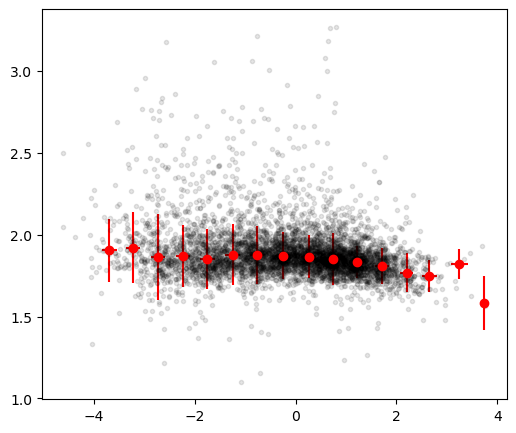

In [72]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = np.asarray([np.float64(x.strip()) for x in dff.P0.values])
Y = dff.logH_new.values

# ind, = np.where((Y<2.5)&(Y>0))
# Y = Y[ind]
# X=X[ind]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(-4,4,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        print(np.mean(xp), 10**np.median(yp))

        
# ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
# ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

# v = np.linspace(0,20000,1000)

# ax.plot(v,0*v+np.median(Y), '--')



# set_axes(ax, (4000,20000), (1,3), fontsize=12)

In [73]:
cf34 = cf3[["DM"]].join(dff, how='left').dropna()
cf34['delta'] = cf34.DMi_new - cf34.DM

cf34 = cf34.dropna()

4569.792650918635 0.057153459385283156
5420.306896551724 0.06425717385633689
6544.586805555556 0.02576015099079143
7474.98418972332 0.056383426323186825
8497.771428571428 0.030901898432858843
9518.27108433735 0.021509349732237837
10507.207407407408 0.02251278948886437
11483.055555555555 0.03805214540618351
12423.148936170213 -0.10151940713586782
13362.545454545454 0.00496575704272928
14408.214285714286 -0.12639098734522847
15406.444444444445 0.0582422864759522
16612.0 0.12868348986308575
17450.363636363636 -0.11688420065826932
18320.75 -0.3833366942978458
19271.333333333332 -0.018821478272158743


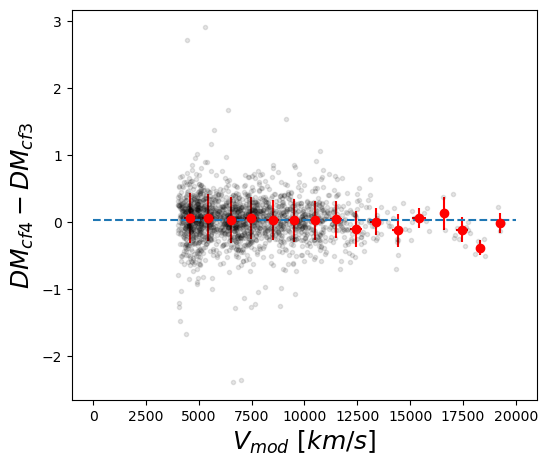

In [74]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = cf34.Vmod.values
Y = cf34.delta.values  

# ind, = np.where((Y<2.5)&(Y>0))
# Y = Y[ind]
# X=X[ind]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        print(np.mean(xp), np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{cf4} - DM_{cf3}$', fontsize=18)

v = np.linspace(0,20000,1000)

ax.plot(v,0*v+np.median(Y), '--')



# set_axes(ax, (4000,20000), (1,3), fontsize=12)

4569.792650918635 70.5151867609386
5420.306896551724 70.3626114969094
6544.586805555556 71.01453510785055
7474.98418972332 70.16960481051821
8497.771428571428 69.48868570937283
9518.27108433735 71.07648230659204
10507.207407407408 67.3148870807446
11483.055555555555 70.71430366778229
12423.148936170213 68.87233819587027
13362.545454545454 75.020426002972
14408.214285714286 74.15683517817602
15406.444444444445 64.41747701881212
16612.0 70.74302573935056
17450.363636363636 68.05395219876176
18320.75 88.20878072849696
19271.333333333332 69.93435585736829


(<AxesSubplot:label='7ed4b99f-ed00-40bf-8030-26b0d32961bd'>,
 <AxesSubplot:label='33515e35-8a85-4173-83b8-2c12202a7a1d'>)

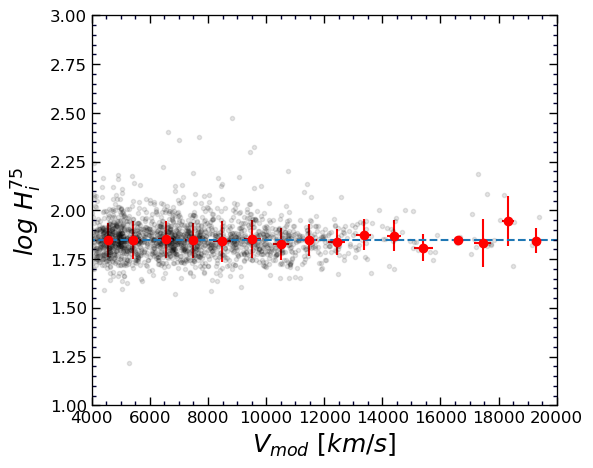

In [75]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = cf34.Vmod.values
Y = cf34.logH_new.values

# ind, = np.where((Y<2.5)&(Y>0))
# Y = Y[ind]
# X=X[ind]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        print(np.mean(xp), 10**np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(0,20000,1000)

ax.plot(v,0*v+np.median(Y), '--')



set_axes(ax, (4000,20000), (1,3), fontsize=12)

In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = cf34.Vmod.values
Y = np.log10(cf34.Vmod.values) - (cf34.DM.values-25)/5.

# ind, = np.where((Y<2.5)&(Y>0))
# Y = Y[ind]
# X=X[ind]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        print(np.mean(xp), 10**np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(0,20000,1000)

ax.plot(v,0*v+np.median(Y), '--')



set_axes(ax, (4000,20000), (1,3), fontsize=12)

In [ ]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


X = dff.Vmod.values
Y = dff.logH_new.values

# ind, = np.where((Y<2.5)&(Y>0))
# Y = Y[ind]
# X=X[ind]

ax.plot(X, Y, 'k.', alpha=0.1)

for i in np.arange(4000,20000,1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        ax.errorbar(np.mean(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='r', ms=6)   
        print(np.mean(xp), 10**np.median(yp))

        
ax.set_xlabel(r'$V_{mod} \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/\/H^{75}_{i}$', fontsize=18)

v = np.linspace(0,20000,1000)

ax.plot(v,0*v+np.median(Y), '--')



set_axes(ax, (4000,20000), (1,3), fontsize=12)